## Import Packages

In [1]:
from matplotlib import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer, StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error, r2_score
import xgboost as xgb
from Helper_Functions import degree_search
from Helper_Functions import polynomial_search
from joblib import dump, load
import json
import statsmodels.api as sm

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

## Read Training Data

In [30]:
training = pd.read_csv("Data/train.csv")

## Data Cleaning

## Datetime Object Breakdown

In [31]:
training["date"] = training.datetime.apply(lambda x : x.split()[0])
training["hour"] = training.datetime.apply(lambda x : x.split()[1].split(":")[0])
training["weekday"] = training.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
training["month"] = training.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])

## Categorical Type Creation

In [32]:
# Mapping to strings
training["season"] = training.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
training["weather"] = training.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

# Mapping to categories

# Creating variable groups for shortcuts
categoryVariables = ["season","weather", "weekday", "month"]
textCategories = ["season","weather", "weekday", 'month']
alreadyCategories = ["holiday", "workingday"]
binVariables = ["hour"]
numericVariables = ['atemp', 'humidity', 'windspeed']

for var in categoryVariables:
    training[var] = training[var].astype("category")

## Exploratory Data Analysis

## Missing Value Analysis

<AxesSubplot:>

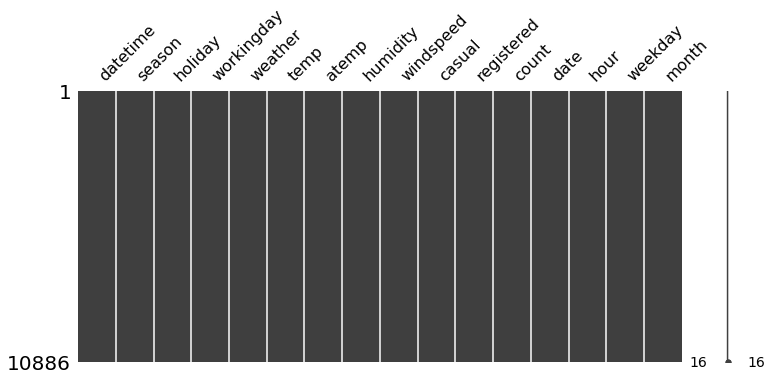

In [35]:
msno.matrix(training,figsize=(12,5))

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

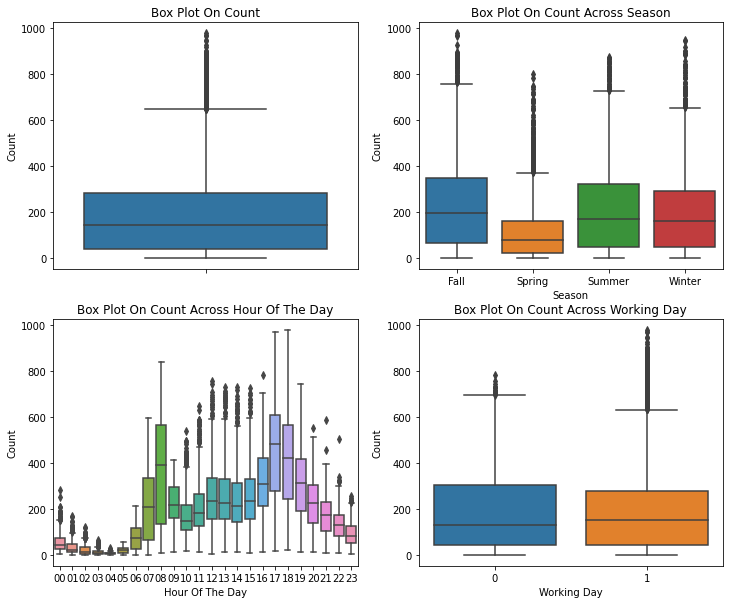

In [36]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=training,y="count",orient="v",ax=axes[0][0])
sn.boxplot(data=training,y="count",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=training,y="count",x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=training,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

## Outlier Removal

In [37]:
# Remove data greater than 4 std away from mean

# numeric_cols = ["temp","atemp","humidity","windspeed","casual","registered","count"]

# print("before outlier removal, " + str(training.shape[0]) + " rows")

# for col in numeric_cols:
#     training = training[np.abs(training[col]-training[col].mean())<=(4*training[col].std())] 
    
# print("after outlier removal, " + str(training.shape[0]) + " rows")

In [ ]:
training.to_csv('cleaned.csv')

## Get Dummies & Bins

In [38]:
# Unrepeatable
bins = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='uniform')
training[binVariables] = bins.fit_transform(training[binVariables])
training[binVariables] = training[binVariables].astype("category")

In [41]:
dummie_cols = pd.get_dummies(training[textCategories+binVariables+['month']]).columns
training = training.join(pd.get_dummies(training[textCategories+binVariables+['month']]))

In [43]:
training.to_csv('cleaned_with_dummies.csv')

## Regression discontinuity with humidity and temperature

### Rentals vs humidity

<AxesSubplot:title={'center':'count'}, xlabel='binedgeshumidity'>

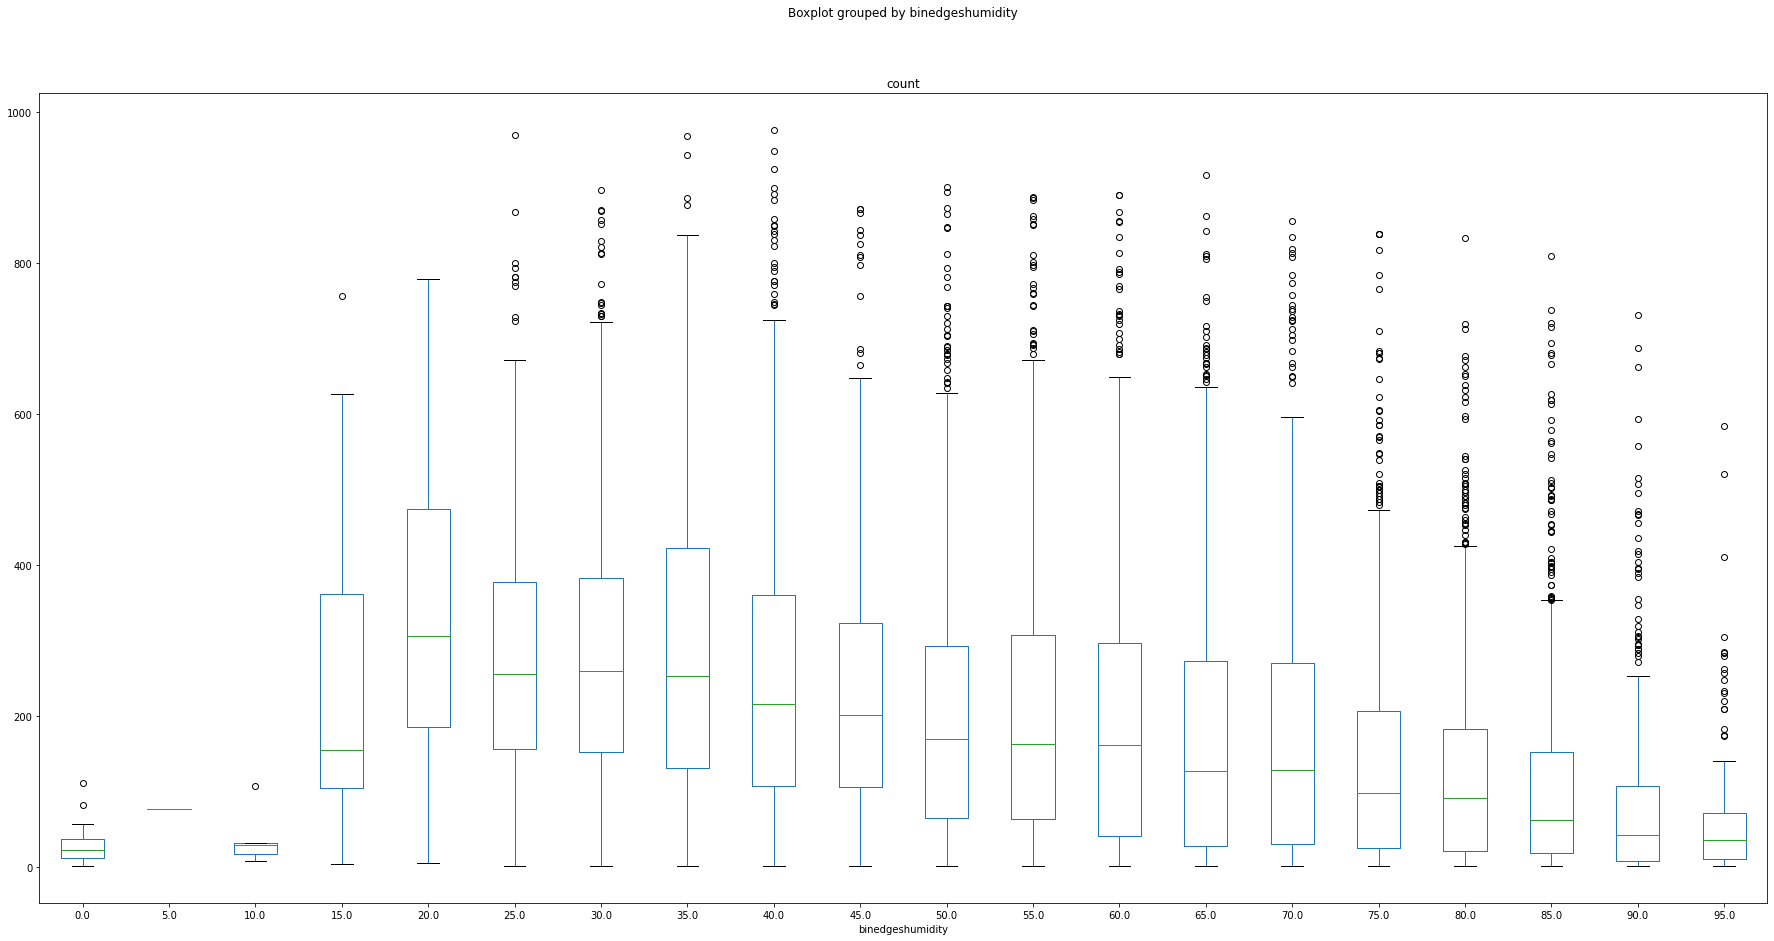

In [221]:
# Discretize humidity through bins in order to create box plots
bins = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')
training['binhumidity'] = bins.fit_transform(training[['humidity']])

# Rename bins with bin edges instead of bin quantiles
mapping = {}
for i in range(len(bins.bin_edges_[0])):
    mapping[i] = round(bins.bin_edges_[0][i], 2)
training['binedgeshumidity'] = training['binhumidity'].map(mapping)

training.boxplot(by='binedgeshumidity',column='count', figsize=(30,15), grid=False)

### Rentals vs temperature

<AxesSubplot:title={'center':'count'}, xlabel='binedges'>

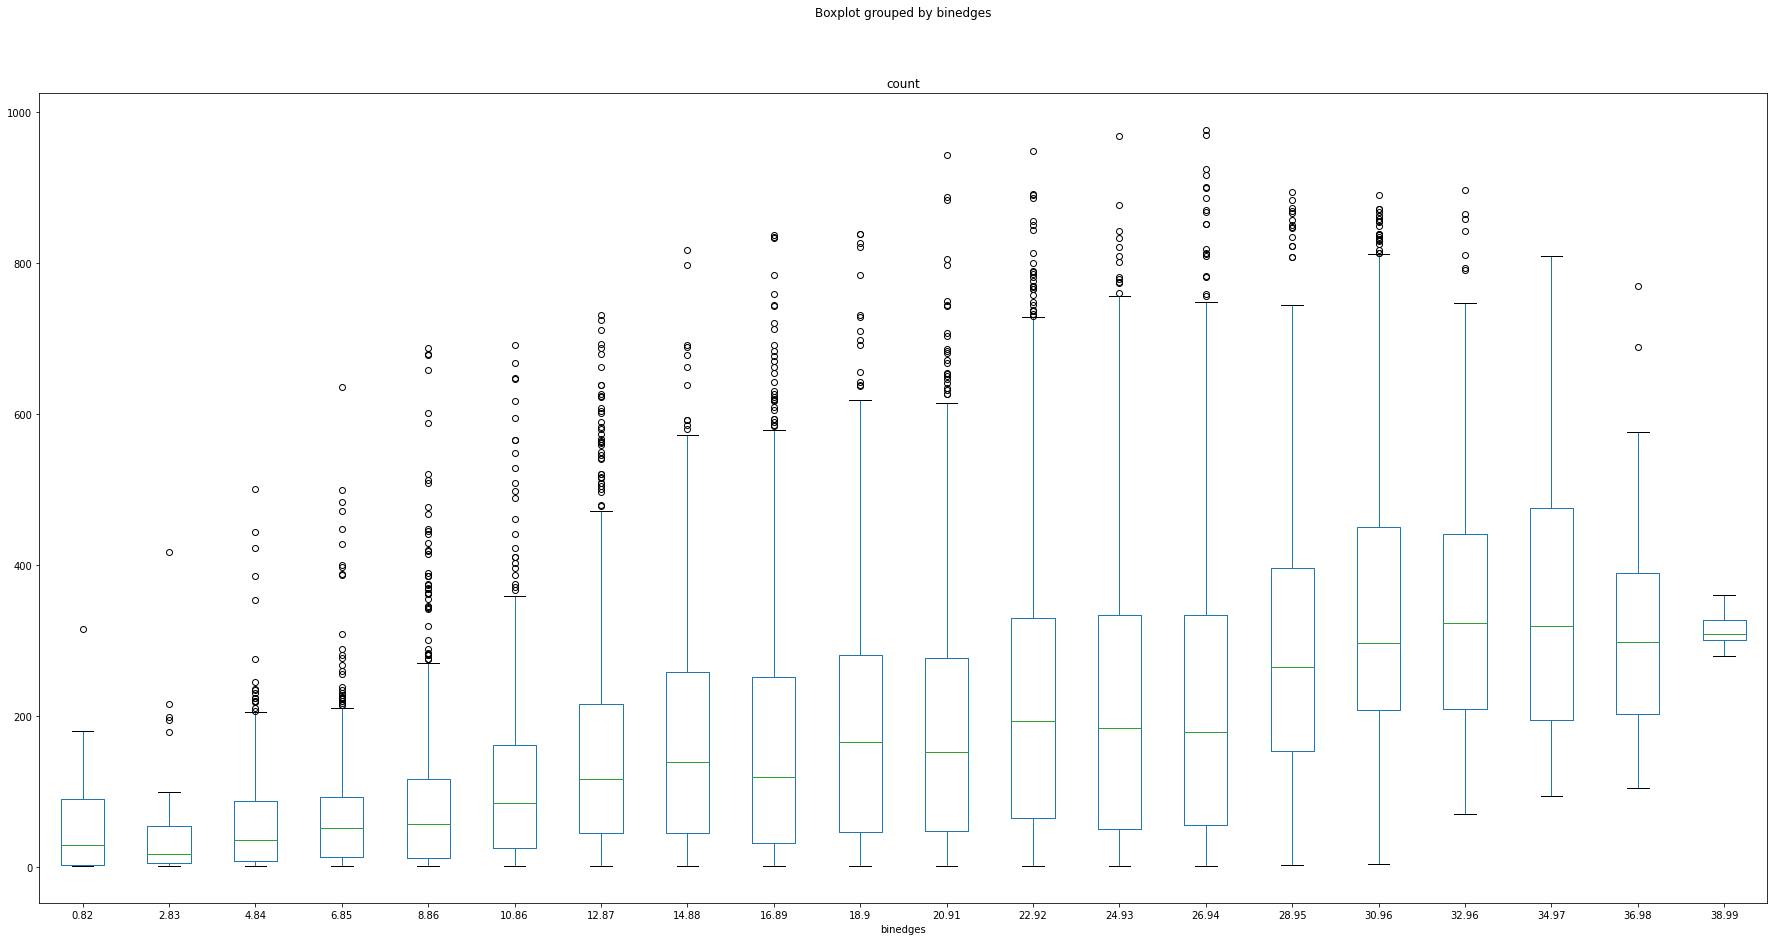

In [222]:
# Discretize temperature through bins in order to create box plots

bins = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')
training['bintemp'] = bins.fit_transform(training[['temp']])
mapping = {}

# Rename bins with bin edges instead of bin quantiles

for i in range(len(bins.bin_edges_[0])):
    mapping[i] = round(bins.bin_edges_[0][i], 2)
training['binedges'] = training['bintemp'].map(mapping)


training.boxplot(by='binedges',column='count', figsize=(30,15), grid=False)


### Rentals vs extreme weathers

In [1]:
training.boxplot(by='weather',column='count', figsize=(30,15), grid=False)

NameError: name 'training' is not defined

### Rentals vs Month

C:\Users\Edwin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     78.48
Date:                Sat, 09 Oct 2021   Prob (F-statistic):          3.97e-171
Time:                        17:50:50   Log-Likelihood:                -71630.
No. Observations:               10886   AIC:                         1.433e+05
Df Residuals:                   10874   BIC:                         1.434e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              90.3665      5.867     

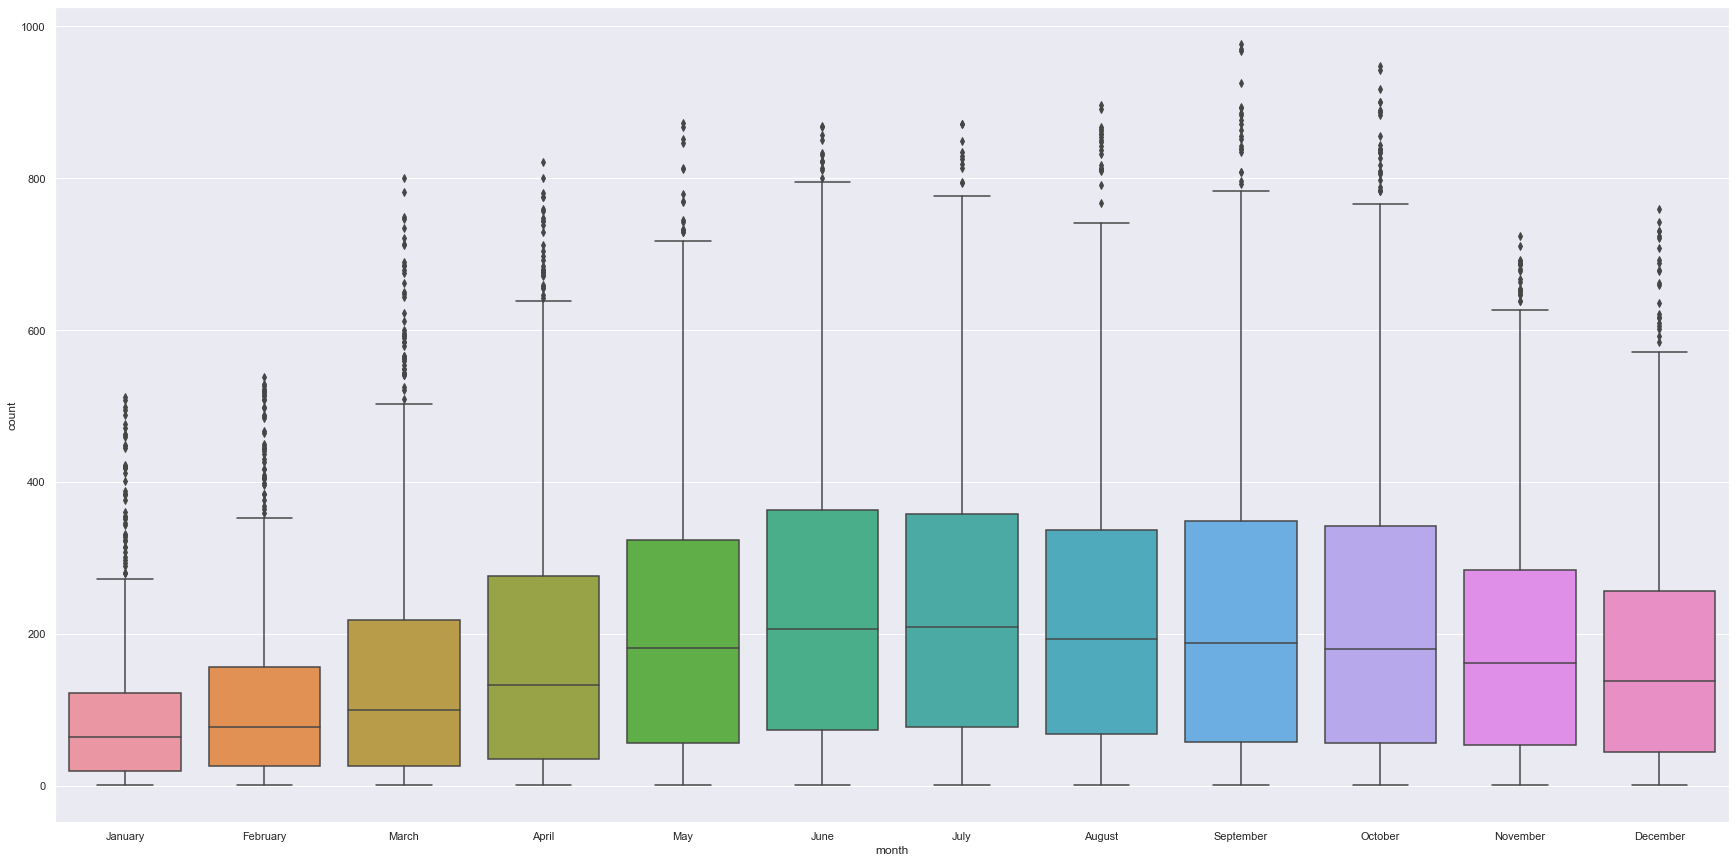

In [274]:
import seaborn as sns
sns.set(rc={'figure.figsize':(30,15)})
p1=sns.boxplot(x='month', 
               y='count', 
               data=training, 
               order=['January', 'February', 'March', 'April', 'May', 'June', 
                      'July', 'August', 'September', 'October', 'November', 'December']